# Schema Explinations

## MongoDB
![MongoDB Schema](images/mongodb_schema.png)

The above schema is the schema we used for the MongoDB database. It is mostly based off of the raw data files we got from the EDDB source with some fields stripped out and a few fields denormalized in certain places to optimize our queries. First, lines with arrows indicate that a field in one collection is related to another collection in a certain way. A solid arrow at the end means that the values can be effecient in join queries because they have indices on those fields. The hollow arrow indicates that the fields are denomalized and placed in the other table for convienent access in queries. Fields in brackets '[]' indicate that they hold an array type. Since the game is mainly focuesed around trading, the listings table is used a lot in our queries. For this reason, we denomalized the commodity_name field into the listings table so that we do not have to perform seperate queries or do a join to get the commodity name. Many queries are also interested in where certain items are located at a station or where a specific service is provided by a station within a given distance. Station names are not unique, so in order to properly identify a station, we also need to get its system. That is why we denormalized the system_name into the stations table. We also decided to keep government and allegiance types denormalized from the factions table as well in the systems_populated and stations tables because we use can use these as groupings to get aggregated data about systems and stations without the need to go to the factions table. Lastly, you can notice that we have a seperate table for all the listings of commodities, but store the selling_modules data at a specific station. This was done due to space constraints. Each listing has much more additional data such as the buy_price, sell_price, supply, demand, etc. Storing this data in the stations table as well would take up too much space and cause other queries to perform poorly as well because so much data would need to be fetched for one station row. The \[selling_modules\] field is kept in the stations because only the id of the modules is stored and takes less space.

## Neo4j
![Neo4j Schema](images/neo4j_schema.png)

The above schema is the shcema used to populate the Neo4j database. We wanted to leverage the ability of Neo4j's relationships, especailly for queries concerned with a limited distance between systems. In this way we added the DISTANCE relationship between each system which creates a connected graph of all the systems in the games galaxy. We limited a relationship to be between two systems when their distance away from each other in light years is under 42 light years. This is the max jump range of the best ship in the game. We also captured the listings data for all commodities by only creating a relationship between the commodity and the station if the demand or supply is greator than 0, indicating the item can be sold/bought there. The splitting of the buy and sell data is also beneficial because usually queries are only looking at one side of the relationship. As can be seen, System nodes contain stations and are controlled by factions. Module nodes are also related to the Station node they are sold at, similar to the Commodity nodes. Modeling the data this way in Neo4j for the game feels very natural because of the graph nature. Everything in the game is based on something located somewhere, needing to get somewhere, or a state at a location. A graph is very suited to dealing with the games data. 

Note: Not as much data or relationships was included in the Neo4j schema and data due to space issues and difficulty populating the database. It takes a long time to put the data currently in the schema with relationships in the database. The database also takes up a lot of space, particularly in main memory when it is loaded in order to perform queries. 

## mySQL

# Difficulties
We experienced a few difficulties when working with the data along the way. 

One of the greatest challanges we faced was populating the Neo4j database. All the raw data that we used for this project was already in JSON and CSV format which was pretty compatible with MongoDB and mySQL, but that was not the case for Neo4j. We had to do a bit of processing to make the data work fit into our schema. Additionally, the data files for certain things are very large, like the listings data. This created millions of relationships in our database. We quickly realized that when you try to put this data in row by row through python, the processes would take days to complete. We also found at that sending too much data at once would if you were lucky throw an error that there was not enough heap memory. If you were unlucky, it would cause your whole computer to freeze while it attempted to process the data and never complete. This made deleting data difficult as well because if a delete query loaded too much into main memory before completing, it would freeze the system as well. We found that we needed to chunk the data and load chunks from a CSV file for it to be efficient, bringing down some creation time from days to a few minutes. Additionally, for queries to run on this large data set, we also had to increase the amount of heap space allocated to Neo4j to at least 2G.

In dealing with the mySQL database, we also ran into a similar issue. There was a variable for the max packet size that could be sent to mySQL when populating a table that was too low on one of our machines. Therefore, when attempting to populate mySQL data, a vague error, "mySQL has gone away!" was given. With some research, we found that we were sending a lot of data to mySQL and needed to adjust the max packet size.

Another issue we ran into was trying to run a path finding algorithm for MongoDB and mySQL using the data gotten from the databases. The data set we have is rather large, so when trying to do the processing in Python, we quickly ran out of memory trying to map every System to eachother. The solution here came from some neat math tricks. When doing a path from one system to another, we create a 3D elipse around the systems and exclude all of the systems that fall outside. This way the memory was not overrun by graph edges.

Enough on our difficulties, all the queries and timings are below!


In [1]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random

from dijkstar import Graph, find_path

import sys
!{sys.executable} -m pip install neo4j-driver
from neo4j import GraphDatabase, basic_auth

!{sys.executable} -m pip install mysql-connector-python
import mysql.connector

import pymongo

# Connect to Databases

In [2]:
#Connect to MongoDB database
client = pymongo.MongoClient("mongodb://localhost:27017/")
eddb = client['EDDB']

#Connect to mySQL database
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="915997582",
    database="EDDB"
)
cursor = db.cursor()

#Connect to Neo4j database
driver = GraphDatabase.driver(
    "bolt://localhost:7687", 
    auth=basic_auth("neo4j", "915997582")
)
session = driver.session()

In [3]:
database_labels = ['MongoDB', 'Neo4j', 'mySQL']

def plot_timings(title, timings_data):
    plt.bar(database_labels, timings_data)
    plt.xlabel("Database")
    plt.ylabel("Time (sec)")
    plt.title(title)
    plt.show()

# Queries
1. How many systems are controlled by allegiences and what populations do they control?
2. Find the commodity with the largest profit margin.
3. Find the system where you can buy a given commodity for the lowest price.
4. Find the system where you can sell a given commodity for the highest price.
5. Given a system and range, find the best commodity to buy and sell locally.
6. Find the nearest system that provides certain services.
7. How many systems does each faction control?
8. Find the rarest module and where to buy it.
9. Find the best path between two systems given the jump range of a ship.
10. Build aggregation of listings data to display the average cost of a given item, total supply, total demand.
11. (Neo4j only) Louvain graph algorithm to get the communities of systems for a given jump range of a ship.

## How many systems are controlled by allegiences and what populations do they control?

In [177]:
def graph_system_controlled_vs_poulation(labels, citizens, systems_controlled):
    normalized_citizens = [x / max(citizens) for x in citizens]
    normalized_systems = [x / max(systems_controlled) for x in systems_controlled]

    # set width of bar
    barWidth = 0.25
    
    # Set position of bar on X axis
    r1 = np.arange(len(citizens))
    r2 = [x + barWidth for x in r1]
    
    # Make the plot
    plt.bar(r1, normalized_systems, color='blue', width=barWidth, edgecolor='white', label='Systems Controlled')
    plt.bar(r2, normalized_citizens, color='red', width=barWidth, edgecolor='white', label='Citizens')
    
    # Add xticks on the middle of the group bars
    plt.xlabel('Allegiance', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(citizens))], labels)

    plt.title("Systems controlled vs Population")

    
    # Create legend & Show graphic
    plt.legend()
    plt.show()

def graph_populations(labels, citizens):
    # Set position of bar on X axis
    r1 = np.arange(len(citizens))
    
    # Make the plot
    plt.bar(r1, citizens, color='red', edgecolor='white')
    
    # Add xticks on the middle of the group bars
    plt.xlabel('Allegiance', fontweight='bold')
    plt.xticks([r for r in range(len(citizens))], labels)

    plt.title("Populations")
    
    # Create show graphic
    plt.show()

### MongoDB

In [270]:
def query_1_mongodb(timings=[]):
    query = [
        {
            '$match': {'$and': [{'allegiance': {'$ne': None}}, {'allegiance': {'$ne': 'None'}}]
            }
        }, {
            '$project': {
                'allegiance': 1, 
                'population': 1
            }
        }, {
            '$group': {
                '_id': '$allegiance', 
                'systems_controlled': {
                    '$sum': 1
                }, 
                'citizens': {
                    '$sum': '$population'
                }
            }
        }, 
    ]
    start = timer()
    results = eddb['systems_populated'].aggregate(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    labels = []
    systems_controlled = []
    citizens = []


    for result in results:
        labels.append(result['_id'])
        systems_controlled.append(result['systems_controlled'])
        citizens.append(result['citizens'])

    return [labels, citizens, systems_controlled]

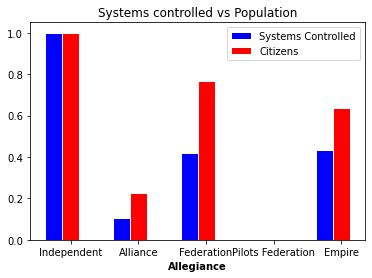

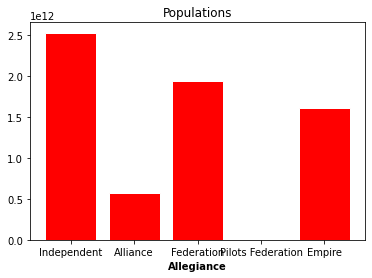

In [271]:
result = query_1_mongodb()
graph_system_controlled_vs_poulation(result[0], result[1], result[2])
graph_populations(result[0], result[1])

### Neo4j

In [192]:
def query_1_neo4j(timings=[]):
    query = """
        MATCH (s:System)
        WHERE NOT s.allegiance = 'None'
        RETURN s.allegiance as allegiance, sum(s.population) as population, count(*) as systems_controlled
        ORDER BY systems_controlled DESC
        """
    start = timer()
    result = session.run(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    labels = []
    systems_controlled = []
    citizens = []

    for row in result:
        labels.append(row['allegiance'])
        systems_controlled.append(row['systems_controlled'])
        citizens.append(row['population'])
    return [labels, citizens, systems_controlled]

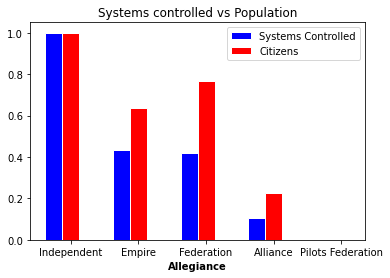

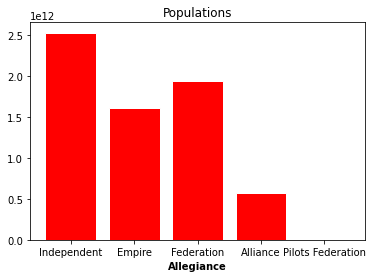

In [193]:
result = query_1_neo4j()
graph_system_controlled_vs_poulation(result[0], result[1], result[2])
graph_populations(result[0], result[1])

### mySQL

In [259]:
def query_1_mysql(timings=[]):
    query = """
    SELECT COUNT(id), allegiance, sum(population) as populations
    FROM system_populated
    WHERE NOT allegiance = -1
    GROUP BY allegiance
    ORDER BY COUNT(id) DESC
    """
    start = timer()
    cursor.execute(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    labels = []
    systems_controlled = []
    citizens = []

    results = cursor.fetchall()
    for row in results:
        labels.append(row[1])
        systems_controlled.append(row[0])
        citizens.append(row[2])

    return [labels, citizens, systems_controlled]

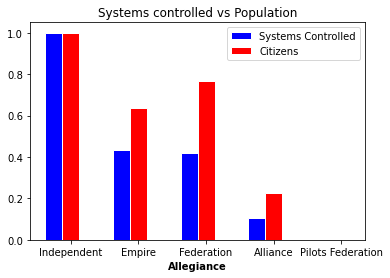

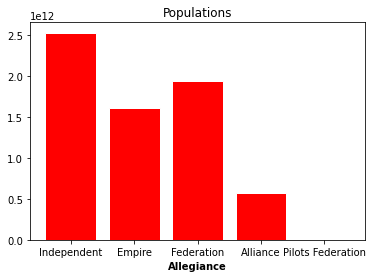

In [181]:
result = query_1_mysql()
graph_system_controlled_vs_poulation(result[0], result[1], result[2])
graph_populations(result[0], result[1])

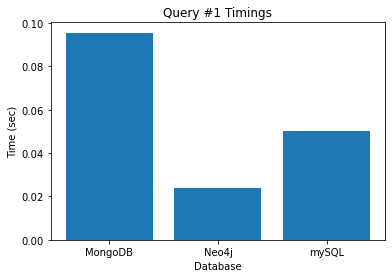

In [282]:
query_1_timings = []
#Run the queries to get their timings
query_1_mongodb(query_1_timings)
query_1_neo4j(query_1_timings)
query_1_mysql(query_1_timings)
#Plot the timings chart
plot_timings("Query #1 Timings", query_1_timings)

### Timings Explination


## 2. Find the commodity with the largest profit margin.
This query uses the aggregated data stored with the commodity to get a commodities profit margin

### MongoDB

In [16]:
def query_2_mongodb(timings = []):
    query = [
        {
            '$project': {
                'name': 1, 
                'id': 1, 
                'max_profit': {
                    '$subtract': [
                        '$max_sell_price', '$min_buy_price'
                    ]
                }, 
                'category': '$category.id', 
                'category_name': '$category.name', 
                'average_price': '$average_price'
            }
        }, {
            '$sort': {
                'max_profit': -1
            }
        }
    ]

    start = timer()
    results = eddb['commodities'].aggregate(query)
    end = timer()
    elapsed_time = end-start
    timings.append(elapsed_time)
    return results

In [17]:
results = query_2_mongodb()
print(list(results)[0])

{'_id': ObjectId('5fad8f308c30de7d2308e98e'), 'id': 362, 'name': 'Tritium', 'max_profit': 48450, 'category': 1, 'category_name': 'Chemicals', 'average_price': 42558}


### Neo4j

In [13]:
def query_2_neo4j(timings = []):
    query = """
            MATCH (c:Commodity)
            WHERE c.max_sell_price - c.min_buy_price IS NOT null
            RETURN c.name, c.max_sell_price - c.min_buy_price as profit_margin
            ORDER BY profit_margin DESC
            LIMIT 1
            """
    start = timer()
    result = session.run(query)
    end = timer()
    elapsed_time = end - start
    timings.append(elapsed_time)
    return result

In [14]:
results = query_2_neo4j()
print(list(results)[0])

<Record c.name='Tritium' profit_margin=48450>


### mySQL

In [18]:
def query_2_mysql(timings = []):
    query = """
    SELECT name, max_sell_price, min_buy_price
    FROM commodity
    ORDER BY (max_sell_price - min_buy_price) DESC
    LIMIT 5
    """

    start = timer()
    cursor.execute(query)
    results = cursor.fetchall()
    end = timer()
    elapsed_time = end - start
    timings.append(elapsed_time)
    return results

In [19]:
results = query_2_mysql()
print(results[0])

('Tritium', 52455, 4005)


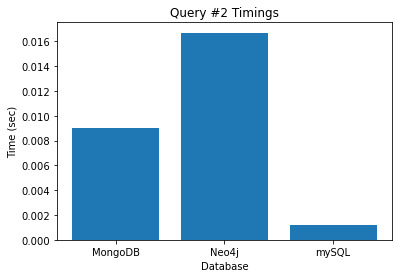

In [20]:
query_2_timings = []
#Run the queries to get the timings
query_2_mongodb(query_2_timings)
query_2_neo4j(query_2_timings)
query_2_mysql(query_2_timings)
#Plot the timings
plot_timings("Query #2 Timings", query_2_timings)

### Timings Explination
This query is a simple query that is only looking at one table for mySQL, one collection for MongoDB, and one node type for Neo4j. mySQL has the best performance of the three databases because it only needs to look at one table. No complex joins are necessary. MongoDB also performs well on queries that involve just one database too. That is why its performance is also significanly better than Neo4j. Neo4j performs the worst on these types of simple queries because of the way data is stored. Nodes of the same type are not stored together and accessing properties of nodes is also more expensive in Neo4j.

## 3. Find the system where you can buy a given commodity for the lowest price.

### MongoDB

In [97]:
#Helper function to query for the commodity id based on the commodity name
def get_commodity_id(commodity_name):
    #query for the commodity id and filter to only include the id field
    filter={'name': commodity_name}
    project={'id': 1}
    result = eddb['commodities'].find(filter=filter, projection=project)
    #return the id from the result
    return result[0]['id']

def get_commodity_name(commodity_id):
    #query for the commodity id and filter to only include the id field
    filter={'id': commodity_id}
    project={'name': 1}
    result = eddb['commodities'].find(filter=filter, projection=project)
    #return the id from the result
    return result[0]['name']

#Helper function to query for the station name based on the commodity id
def get_station_names(station_ids):
    #query for the station name and project only the station name and system id
    filter={'id': {'$in': station_ids}}
    project={'name': 1, 'system_id': 1}
    result = eddb['stations'].find(filter=filter, projection=project)
    return result

def get_system_name(system_id):
    filter={'id': system_id}
    project={'name': 1}
    result = eddb['systems_populated'].find(filter=filter, projection=project)
    return result

In [55]:
def query_3_mongodb(commodity_name, timings=[]):
    start = timer()
    commodity_id = get_commodity_id(commodity_name)
    #ensure the supply is greater than zero otherwise there is nothing to buy at the station and the buy_price will be zero
    query = [
        {
            '$match': {
                '$and': [
                    {
                        'commodity_id': commodity_id
                    }, {
                        'supply': {
                            '$gt': 0
                        }
                    }
                ]
            }
        }, {
            '$group': {
                '_id': '$buy_price', 
                'stations': {
                    '$push': '$station_id'
                }
            }
        }, {
            '$sort': {
                '_id': 1
            }
        }, {
            '$limit': 1
        }, {
            '$unwind': {
                'path': '$stations', 
                'preserveNullAndEmptyArrays': False
            }
        }
    ]
    result = eddb['listings'].aggregate(query)
    #get the station id from the result
    station_ids = []
    for row in result:
        station_ids.append(row['stations'])
    station_names = get_station_names(station_ids)

    result_list = []
    for row in station_names:
        system_name = list(get_system_name(row['system_id']))[0]['name']
        result_list.append({"station_name": row['name'], "system_name": system_name})
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return result_list

In [56]:
commodity_name = 'Liquid oxygen'
result = query_3_mongodb(commodity_name)
for row in result:
    print(f'The station, {row["station_name"]} in {row["system_name"]}, has the lowest price to buy {commodity_name}')

The station, Bardeen Terminal in Aegilips, has the lowest price to buy Liquid oxygen


### Neo4j

In [30]:
def query_3_neo4j(commodity_name, timings=[]):
    query = f"""
        MATCH (c:Commodity {{name: '{commodity_name}'}})
        WITH c as commodity
        MATCH (commodity)-[r:BUY_AT]->(s:Station)
        WITH r.buy_price as buy_price, collect(s) as stations
        ORDER BY buy_price
        LIMIT 1
        UNWIND stations as station
        MATCH (station)<-[:CONTAINS]-(sys:System)
        RETURN station.name as station_name, sys.name as system_name, buy_price
        """
    start = timer()
    result = session.run(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return result

In [31]:
commodity_name = 'Liquid oxygen'
result = query_3_neo4j(commodity_name)
for row in result:
    print(f"{commodity_name} can be bought for the lowest price at {row['station_name']} in {row['system_name']} for {row['buy_price']}.")

Liquid oxygen can be bought for the lowest price at Bardeen Terminal in Aegilips for 81.


mySQL

In [61]:
def query_3_mySQL(commodity_name, timings=[]):
    # get price
    query = """
    SELECT min_buy_price
    FROM commodity
    WHERE name = "{name}"
    """.format(name=commodity_name)

    start = timer()
    cursor.execute(query)

    results = cursor.fetchall()

    price = 0

    for x in results:
        price = x[0]

    # where is it
    query = """
    SELECT system_populated.name, station.name
    FROM listing
    JOIN station ON station.id=listing.station_id
    JOIN system_populated ON station.system_id=system_populated.id
    JOIN commodity ON listing.commodity_id=commodity.id
    WHERE commodity.name = "{name}" AND listing.buy_price = {price}
    """.format(name=commodity_name, price=price)

    cursor.execute(query)

    results = cursor.fetchall()
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return results


In [63]:
commodity_name = 'Liquid oxygen'
result = query_3_mySQL(commodity_name)
for row in result:
    print(f"The station, {row[1]} in {row[0]}, has the best price for {commodity_name}")

The station, Bardeen Terminal in Aegilips, has the best price for Liquid oxygen


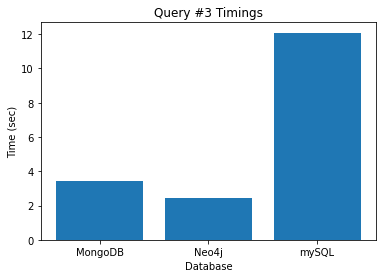

In [283]:
commodity_name = 'Liquid oxygen'
query_3_timings = []
#Run the queries to get thier timings
query_3_mongodb(commodity_name, query_3_timings)
query_3_neo4j(commodity_name, query_3_timings)
query_3_mySQL(commodity_name, query_3_timings)
#Plot the timings
plot_timings("Query #3 Timings", query_3_timings)

### Timings Explination
Neo4j performs best in this type of query because it is following the relationships for sell and buy prices. MongoDB and Neo4j need to look at every listing, including listings where an object may be sold/bought. Hoever, Neo4j has removed all these links where an item can not be bought or sold when the relationships were created. MongoDB also performs better because it is split into multiple queries. First, the results are gotten on the listings before resolving a small number of commodity names, station names, and system names. mySQL runs the slowest because it uses joins for all the tables, systems, stations, commodities, and listings, in order to obtain its results. These join queries are very costly.

## 4. Find the station where you can sell a given commodity for the highest price.

### MongoDB

In [57]:
def query_4_mongodb(commodity_name, timings=[]):
    start = timer()
    commodity_id = get_commodity_id(commodity_name)
    #query for the station id where the commodity can bought for the lowest price
    #ensure the demand is greater than zero otherwise there is nothing to sell at the station and the sell_price will be zero
    query = [
        {
            '$match': {
                '$and': [
                    {
                        'commodity_id': commodity_name
                    }, {
                        'demand': {
                            '$gt': 0
                        }
                    }
                ]
            }
        }, {
            '$group': {
                '_id': '$sell_price', 
                'stations': {
                    '$push': '$station_id'
                }
            }
        }, {
            '$sort': {
                '_id': -1
            }
        }, {
            '$limit': 1
        }, {
            '$unwind': {
                'path': '$stations', 
                'preserveNullAndEmptyArrays': False
            }
        }
    ]
    result = eddb['listings'].aggregate(query)
    #get the station id from the result
    station_ids = []
    for row in result:
        station_ids.append(row['stations'])
    station_names = get_station_names(station_ids)

    result_list = []
    for row in station_names:
        system_name = list(get_system_name(row['system_id']))[0]['name']
        result_list.append({"station_name": row['name'], "system_name": system_name})

    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return result_list

In [51]:
commodity_name = 'Beer'
result = query_4_mongodb(commodity_name)
for row in result:
    print(f'The station, {row["station_name"]} in {row["system_name"]}, has the lowest price to buy {commodity_name}')

The station, Krylov Base in HERZ 10688, has the lowest price to buy Beer
The station, Stabenow Reformatory in Peregrina, has the lowest price to buy Beer
The station, Lorrah Reach in HIP 101613, has the lowest price to buy Beer
The station, VanderMeer Legacy in Lyncis Sector DB-X c1-9, has the lowest price to buy Beer


### Neo4j

In [25]:
def query_4_neo4j(commodity_name, timings=[]):
    query = f"""
        MATCH (c:Commodity {{name: '{commodity_name}'}})
        WITH c as commodity
        MATCH (commodity)-[r:SELL_AT]->(s:Station)
        WITH r.sell_price as sell_price, collect(s) as stations
        ORDER BY sell_price DESC
        LIMIT 1
        UNWIND stations as station
        MATCH (station)<-[:CONTAINS]-(sys:System)
        RETURN station.name as station_name, sys.name as system_name, sell_price
        """
    start = timer()
    result = session.run(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)
    
    return result

In [27]:
commodity_name = 'Beer'
result = query_4_neo4j(commodity_name)
for row in result:
    print(f"{commodity_name} can be sold for the highest price at {row['station_name']} in {row['system_name']} for {row['sell_price']}.")

Beer can be sold for the highest price at Stabenow Reformatory in Peregrina for 4763.
Beer can be sold for the highest price at VanderMeer Legacy in Lyncis Sector DB-X c1-9 for 4763.
Beer can be sold for the highest price at Lorrah Reach in HIP 101613 for 4763.
Beer can be sold for the highest price at Krylov Base in HERZ 10688 for 4763.


### mySQL

In [59]:
def query_4_mysql(commodity_name, timings=[]):
    # get price
    query = """
    SELECT max_sell_price
    FROM commodity
    WHERE name = "{name}"
    """.format(name=commodity_name)

    start = timer()
    cursor.execute(query)

    results = cursor.fetchall()

    price = 0

    for x in results:
        price = x[0]

    # where is it
    query = """
    SELECT system_populated.name, station.name
    FROM listing
    JOIN station ON station.id=listing.station_id
    JOIN system_populated ON station.system_id=system_populated.id
    JOIN commodity ON listing.commodity_id=commodity.id
    WHERE commodity.name = "{name}" AND listing.sell_price = {price}
    """.format(name=commodity_name, price=price)

    cursor.execute(query)

    results = cursor.fetchall()
    end = timer()

    elapsed_timer = end - start
    timings.append(elapsed_timer)

    return results

In [60]:
commodity_name = 'Beer'
result = query_4_mysql(commodity_name)
for row in result:
        print(f'{row[1]} in {row[0]} is where {commodity_name} can be sold for the highest price.')

VanderMeer Legacy in Lyncis Sector DB-X c1-9 is where Beer can be sold for the highest price.
Stabenow Reformatory in Peregrina is where Beer can be sold for the highest price.
Lorrah Reach in HIP 101613 is where Beer can be sold for the highest price.
Krylov Base in HERZ 10688 is where Beer can be sold for the highest price.


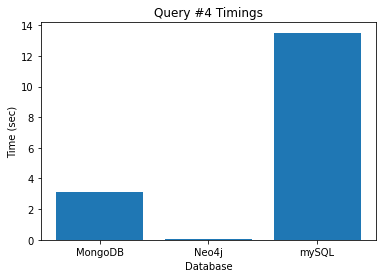

In [286]:
commodity_name = 'Beer'
query_4_timings = []
#Run the queries to get their timings
query_4_mongodb(commodity_name, query_4_timings)
query_4_neo4j(commodity_name, query_4_timings)
query_4_mysql(commodity_name, query_4_timings)
#Plot the timings
plot_timings("Query #4 Timings", query_4_timings)

### Timings Explination
**The explination for this query is the same as for query #3 since they are doing similar operations.**

Neo4j performs best in this type of query because it is following the relationships for sell and buy prices. MongoDB and Neo4j need to look at every listing, including listings where an object may not be sold/bought based on the demand or supply of the item being zero. Hoever, Neo4j has removed all these links where an item can not be bought or sold when the relationships were created. MongoDB also performs better because it is split into multiple queries. First, the results are gotten on the listings before resolving a small number of commodity names, station names, and system names. mySQL runs the slowest because it uses joins for all the tables: systems, stations, commodities, and listings, in order to obtain its results. These join queries are very costly.

## 5. Given a system and range, find the best commodity to buy and sell locally.

### MongoDB

In [105]:
def query_5_mongodb(current_system_name, distance, timings=[]):
    #Get the coordinates for the original system
    start = timer()
    filter={'name': current_system_name}
    project={'x': 1, 'y': 1, 'z': 1}
    result = list(eddb['systems_populated'].find(filter=filter, projection=project))
    x = result[0]['x']
    y = result[0]['y']
    z = result[0]['z']

    #Get all the systems in the range
    query = [
        {'$addFields': {'squared_distance': {'$sum': [{'$pow': [{'$subtract': ['$x', x]}, 2]}, {'$pow': [{'$subtract': ['$y', y]}, 2]}, {'$pow': [{'$subtract': ['$z', z]}, 2]}]}}}, 
        {'$match': {'squared_distance': {'$lt': distance*distance}}}, {'$project': {'name': 1, 'id': 1}}
    ]
    systems = list(eddb['systems_populated'].aggregate(query))
    system_list = []
    for system in systems:
        system_list.append(system['id'])

    #Get all the station ids
    filter={'system_id': {'$in': system_list}}
    project={'id': 1, 'name': 1, 'system_id': 1}
    stations_result = list(eddb['stations'].find(filter=filter, projection=project)) 
    stations_list = []
    for station in stations_result:
        stations_list.append(station['id'])
    
    max_sell_price_query = [
        {'$match': {'$and': [{'station_id': {'$in': stations_list}}, {'demand': {'$gt': 0}}] }}, 
        {'$sort': {'sell_price': -1}}, 
        {'$group': {
                '_id': '$commodity_id', 
                'max_sell_price': {'$first': '$sell_price'},
                'station_id': {"$first": "$station_id"}
            }
        }
    ]
    min_buy_price_query = [
        {'$match': {'$and': [ {'station_id': {'$in': stations_list}}, {'supply': {'$gt': 0}}]}}, 
        {'$sort': {'buy_price': 1}}, 
        {'$group': {
                '_id': '$commodity_id', 
                'min_buy_price': {'$first': '$buy_price'},
                'station_id': {"$first": "$station_id"}
            }
        }
    ]
    sell_prices = list(eddb['listings'].aggregate(max_sell_price_query))
    buy_prices = list(eddb['listings'].aggregate(min_buy_price_query))
    #Find the commodity with the best profit
    best_commodity = {}
    for s_row in sell_prices:
        for b_row in buy_prices:
            if s_row['_id'] == b_row['_id']:
                profit = s_row['max_sell_price'] - b_row['min_buy_price']
                #If a commodity entry is already there compare for the best profit, otherwise populate the best commodity dict
                if 'profit' in best_commodity:
                    if profit > best_commodity['profit']:
                        best_commodity = {'commodity_id': b_row['_id'], 'profit': profit, "src_station": b_row['station_id'], "dst_station": s_row['station_id']}
                else:
                    best_commodity = {'commodity_id': b_row['_id'], 'profit': profit, "src_station": b_row['station_id'], "dst_station": s_row['station_id']}
    #Get the string names for the commodity, stations, and systems
    commodity_name = get_commodity_name(best_commodity['commodity_id'])
    for station in stations_result:
        if station['id'] == best_commodity['src_station']:
            src_station = station['name']
            for system in systems:
                if system['id'] == station['system_id']:
                    src_system = system['name']
        if station['id'] == best_commodity['dst_station']:
            dst_station = station['name']
            for system in systems:
                if system['id'] == station['system_id']:
                    dst_system = system['name']
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return {'commodity_name': commodity_name, 'profit': best_commodity['profit'], 'src_system': src_system, 'src_station': src_station, 'dst_system': dst_system, 'dst_station': dst_station}

In [106]:
current_system_name = 'Nerthus'
distance = 24
result = query_5_mongodb(current_system_name, distance)
print(f"The most profitable commodity is {result['commodity_name']} at a profit of {result['profit']} buying from {result['src_station']} in {result['src_system']} and selling to {result['dst_station']} in {result['dst_system']}")

The most profitable commodity is Tritium at a profit of 46514 buying from Hirase Installation in LTT 8456 and selling to Hire Gateway in LTT 9387


### Neo4j

In [74]:
def query_5_neo4j(current_system_name, distance, timings=[]):
    #Query to get a list of buyings and sellings at each station
    query = f"""
            MATCH result=(sys:System{{name:'{current_system_name}'}})-[r:DISTANCE]-(otherSys:System)
            WHERE r.lightYears < {distance}
            WITH collect(otherSys)+sys as systems
            UNWIND systems as system
            MATCH (system)-[:CONTAINS]->(station:Station)
            WITH system, station
            MATCH (c:Commodity)-[r:BUY_AT]->(station)
            WITH system, station, collect({{commodity_name:c.name, buy_price: r.buy_price}}) as buy_listings
            MATCH (c:Commodity)-[r:SELL_AT]->(station)
            RETURN system.name as system_name, station.name as station_name, buy_listings, collect({{commodity_name:c.name, sell_price: r.sell_price}}) as sell_listings
            """
    start = timer()
    result = session.run(query)
    buy_listings = {}
    sell_listings = {}
    #Go thorugh each result to find which commodity prices are the best and from which station they are best
    for row in result:
        system_name = row['system_name']
        station_name = row['station_name']
        for listing in row['buy_listings']:
            commodity_name = listing['commodity_name']
            if not commodity_name in buy_listings or buy_listings[commodity_name]['buy_price'] > listing['buy_price']:
                buy_listings[commodity_name] = {'buy_price': listing['buy_price'], 'station': station_name, 'system': system_name}
        for listing in row['sell_listings']:
            commodity_name = listing['commodity_name']
            if not commodity_name in sell_listings or sell_listings[commodity_name]['sell_price'] < listing['sell_price']:
                sell_listings[commodity_name] = {'sell_price': listing['sell_price'], 'station': station_name, 'system': system_name}

    #Go through all the best lisitings and choose the commodity with the highest profit margin
    best_listing = {}
    commodity_names = buy_listings.keys()
    for name in commodity_names:
        if name in sell_listings:
            profit = sell_listings[name]['sell_price']-buy_listings[name]['buy_price']
            if not best_listing or best_listing['profit'] < profit:
                best_listing = {'name': name, 'profit': profit}
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    src_station = buy_listings[best_listing['name']]['station']
    src_system = buy_listings[best_listing['name']]['system']
    dst_station = sell_listings[best_listing['name']]['station']
    dst_system = sell_listings[best_listing['name']]['system']
    return {"src_station": src_station, "src_system": src_system, "dst_station": dst_station, "dst_system": dst_system, 
            "commodity_name": best_listing["name"], "profit": best_listing["profit"]}

In [72]:
current_system_name = 'Nerthus'
distance = 24
result = query_5_neo4j(current_system_name, distance)
print(f"The most profitable commodity is {result['commodity_name']} at a profit of {result['profit']} buying from {result['src_station']} in {result['src_system']} and selling to {result['dst_station']} in {result['dst_system']}")

{'buy_price': 9447, 'station': 'Walotsky Landing', 'system': 'NLTT 57668'}
{'sell_price': 11928, 'station': 'Heaviside Arsenal', 'system': 'Isis'}
The most profitable commodity is Tritium at a profit of 46514 buying from Hirase Installation in LTT 8456 and selling to Hire Gateway in LTT 9387


mySQL

In [70]:
def query_5_mysql(current_system_name, distance, timings=[]):
    query = """
    SELECT x, y, z
    FROM system_populated
    WHERE name = '{name}'
    """.format(name=current_system_name)

    start = timer()
    cursor.execute(query)

    results = cursor.fetchall()

    coords = results[0]

    # Get all stations within range with listings
    query = """
    SELECT station.name, station.id, sys.name, sys.id, commodity.name, commodity.id, listing.sell_price, listing.buy_price, listing.supply, listing.demand
    FROM system_populated as sys
    JOIN station ON station.system_id = sys.id
    JOIN listing ON station.id = listing.station_id
    JOIN commodity ON commodity.id=listing.commodity_id
    WHERE POWER({trade_range}, 2) > (POWER(sys.x - {x}, 2) + POWER(sys.y - {y}, 2) + POWER(sys.z - {z}, 2))
    """.format(trade_range=distance, x=coords[0], y=coords[1], z=coords[2])

    cursor.execute(query)

    results = cursor.fetchall()

    min_buy = dict()
    max_sell = dict()
    profit = dict()

    for x in results:
        if x[8] > 0:
            if x[4] in min_buy:
                if min_buy[x[4]] > x[7]:
                    min_buy[x[4]] = x[7]
            else:
                min_buy[x[4]] = x[7]

    for x in results:
        if x[4] in min_buy and x[9] > 0:
            if x[4] in max_sell:
                if max_sell[x[4]] < x[6]:
                    max_sell[x[4]] = x[6]
            else:
                max_sell[x[4]] = x[6]
                
    for x in min_buy:
        if x in max_sell:
            profit[x] = max_sell[x] - min_buy[x]

    max_profit_commodity = max(profit, key = lambda k: profit[k])
    max_profit = profit[max_profit_commodity]
    buy_location = None
    sell_location = None

    for x in results:
        if x[6] == max_sell[max_profit_commodity]:
            sell_location = x
        if x[7] == min_buy[max_profit_commodity]:
            buy_location = x
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return {"src_station": buy_location[0], "src_system": buy_location[2], "dst_station": sell_location[0], "dst_system": sell_location[2], "commodity_name": buy_location[4], "profit": max_profit}


In [73]:
current_system_name = 'Nerthus'
distance = 24
result = query_5_mysql(current_system_name, distance)
print(f"The most profitable commodity is {result['commodity_name']} at a profit of {result['profit']} buying from {result['src_station']} in {result['src_system']} and selling to {result['dst_station']} in {result['dst_system']}")

ValueError: max() arg is an empty sequence

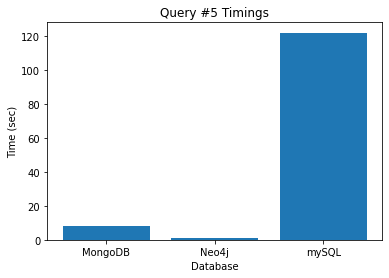

In [287]:
current_system_name = 'Nerthus'
distance = 24
query_5_timings = []
#Run the queries to get thier timings
query_5_mongodb(current_system_name, distance, query_5_timings)
query_5_neo4j(current_system_name, distance, query_5_timings)
query_5_mysql(current_system_name, distance, query_5_timings)
#Plot the timings
plot_timings("Query #5 Timings", query_5_timings)

### Timings Explination
Neo4j performs the best in this type of query because it leverages the fact that it already stores its view of all the systems in a connected graph. Because of this it does not need to calculate distances between the nodes at run time, only compare distances for already stored relationships. Additionally, it is able to easily follow relatioships to get all the buy and sell relationships for commodities which exclude data where a commodity is not sold at a certain station. MongoDB and mySQL both have to examine listings where a commodity is not bought or sold somewhere and exclude that data item from calculations. Both mySQL and Neo4j also need to calculate distances between systems at run time as well. The MongoDB query runs much faster because it splits data up into seperate queries. It first cuts down on the amount of data by finding the relevant systems in the range and all the stations, then calculating the best commodities. Lastly, mySQL performs very poorly in this type of query because it joins all the tables together which is very costly. It then has to do calculations on a huge data set in order to shrink things down to the correct results due to joining all the tables together. Note: mySQL and neo4j also return a very large data set which needs to be sorted to get the correct result while mongodb's query has methods to only return the best profit listing for each commodity requiring less data manipulation. 

## 6. Find the nearest system that provides certain services

### MongoDB

In [289]:
def query_6_mongodb(current_system_name, service_name, timings=[]):
    service_name = 'has_'+service_name
    
    start = timer()
    filter={'name': current_system_name}
    project={'x': 1, 'y': 1, 'z': 1}
    result = list(eddb['systems_populated'].find(filter=filter, projection=project))
    #Current system coordinates
    x = result[0]['x']
    y = result[0]['y']
    z = result[0]['z']

    #Get the list of all the system ids with the specific service
    filter={service_name: True}
    project={'system_id': 1, 'name': 1}
    station_result = list(eddb['stations'].find(filter=filter, projection=project))
    system_list = []
    for station in station_result:
        if not station['system_id'] in system_list:
            system_list.append(station['system_id'])
    
    query = [
        {'$match': {'id': {'$in': system_list}}}, 
        {'$addFields': {'squared_distance': {'$sum': [{'$pow': [{'$subtract': ['$x', x]}, 2]}, {'$pow': [{'$subtract': ['$y', y]}, 2]}, {'$pow': [{'$subtract': ['$z', z]}, 2]}]}}}, 
        {'$sort': {'squared_distance': 1}},
        {'$limit': 1},
        {'$project': {'name': 1, 'id': 1}}
    ]
    system_result = list(eddb['systems_populated'].aggregate(query))
    system_name = system_result[0]['name']
    system_id = system_result[0]['id']

    resulting_stations = []
    for station in station_result:
        if station['system_id'] == system_id:
            resulting_stations.append(station['name'])

    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return {'system_name': system_name, 'stations': resulting_stations}

In [119]:
current_system_name = 'Nerthus'
service = 'blackmarket'
result = query_6_mongodb(current_system_name, service)
for station in result['stations']:
    print(f"The closest station with {service} is {station} in {result['system_name']}")

The closest station with blackmarket is Shinn Orbital in Two Ladies
The closest station with blackmarket is Beekman Platform in Two Ladies
The closest station with blackmarket is Betancourt Horizons in Two Ladies
The closest station with blackmarket is Julian Hub in Two Ladies


### Neo4j

In [122]:
def query_6_neo4j(current_system_name, service, timings=[]):
    query = f"""
        MATCH (sys: System {{name: '{current_system_name}'}})
        WITH sys.x as x, sys.y as y , sys.z as z
        MATCH (s: Station)
        WHERE '{service}' IN s.services
        WITH s, x, y, z
        MATCH (s)<-[:CONTAINS]-(sys:System)
        RETURN sys.name as system, collect(s.name) as stations, (x-sys.x)^2 + (y-sys.y)^2 + (z-sys.z)^2 as distanceSquared
        ORDER BY distanceSquared
        LIMIT 1
        """
    start = timer()
    result = session.run(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return list(result)

In [123]:
current_system_name = 'Nerthus'
service = 'blackmarket'
result = query_6_neo4j(current_system_name, service)
for station in result[0]['stations']:
    print(f"The closest station with {service} is {station} in {result[0]['system']}")

The closest station with blackmarket is Shinn Orbital in Two Ladies
The closest station with blackmarket is Beekman Platform in Two Ladies
The closest station with blackmarket is Betancourt Horizons in Two Ladies
The closest station with blackmarket is Julian Hub in Two Ladies


### mySQL

In [142]:
def query_6_mysql(current_system_name, service, timings=[]):
    service = 'has_'+service

    # Get Current System Coords
    query = """
    SELECT x, y, z
    FROM system_populated
    WHERE name = '{name}'
    """.format(name=current_system_name)

    start = timer()
    cursor.execute(query)

    results = cursor.fetchall()

    coords = results[0]

    query = """
    SELECT sys.name, station.name, (POWER(sys.x - {x}, 2) + POWER(sys.y - {y}, 2) + POWER(sys.z - {z}, 2)) AS Distance
    FROM station
    JOIN system_populated AS sys
    ON sys.id = station.system_id
    WHERE {service} = 1 AND sys.id IN (
        SELECT sub.id FROM (
            SELECT sys.id, (POWER(sys.x - {x}, 2) + POWER(sys.y - {y}, 2) + POWER(sys.z - {z}, 2)) AS Distance
            FROM station
            JOIN system_populated AS sys
            ON sys.id = station.system_id
            WHERE {service} = 1
            ORDER BY Distance ASC
            LIMIT 1
        ) sub
    )
    """.format(service=service, x=coords[0], y=coords[1], z=coords[2])

    cursor.execute(query)

    results = cursor.fetchall()
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return results

In [143]:
current_system_name = 'Nerthus'
service = 'blackmarket'
result = query_6_mysql(current_system_name, service)
for row in result:
    print(f"The closest station with {service} is {row[1]} in {row[0]}")

The closest station with blackmarket is Shinn Orbital in Two Ladies
The closest station with blackmarket is Beekman Platform in Two Ladies
The closest station with blackmarket is Betancourt Horizons in Two Ladies
The closest station with blackmarket is Julian Hub in Two Ladies


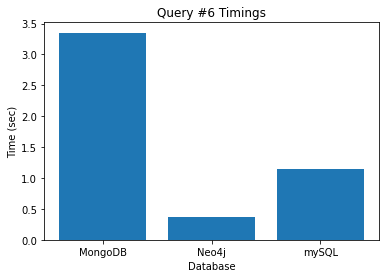

In [291]:
current_system_name = 'Nerthus'
service = 'blackmarket'
query_6_timings = []
#Execute the queries to get their timings
query_6_mongodb(current_system_name, service, query_6_timings)
query_6_neo4j(current_system_name, service, query_6_timings)
query_6_mysql(current_system_name, service, query_6_timings)
#Plot the timings
plot_timings("Query #6 Timings", query_6_timings)

## Timings Explination
Neo4j performs the best in this kind of query because it can leverage its relationships again. Instead of needing to match a system id by looking through the whole systems table, it can quickly follow a relationship from the station to match it to the system. mySQL outperforms MongoDB in this query because mySQL is able to limit its search space with a sub-query first. It first finds all the systems within the desired range before looking at the individual stations which is a larger table. MongoDB first finds all stations with a given service. Because the stations is a larger dataset, it takes more time instead of reducing the number of stations by finding the systems first. Both MongoDB and mySQL have to get data from multiple tables which is why Neo4j works better in this type of query.

## 7. Find the number of systems each faction controls

### MongoDB

In [202]:
def query_7_mongodb(timings=[]):
    query = [
        {'$project': {'controlling_minor_faction': 1}}, 
        {'$group': {
                '_id': '$controlling_minor_faction', 
                'total': {'$sum': 1}
            }
        }, 
        {'$sort': {'total': -1}},
        {'$limit': 25}
    ]
    start = timer()
    result = eddb['systems_populated'].aggregate(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return result

In [203]:
result = query_7_mongodb()
for row in result:
    print(f"{row['_id']} controls {row['total']}")

Likedeeler of Michel controls 102
The Dukes of Mikunn controls 101
Brazilian League of Pilots controls 98
DaVinci Corp. controls 93
Nagii Union controls 92
Communist Interstellar Union controls 89
Delta Squadron controls 88
Celestial Light Brigade controls 88
Guardians of Harmony controls 85
The Winged Hussars controls 83
Sap Core Legion controls 79
The L.O.S.P. controls 71
Wolf 406 Transport & Co controls 69
The 9th Legion controls 69
Canonn controls 69
Dark Echo controls 68
East India Company controls 65
Wolves of Jonai controls 65
SSL Interstellar PLC controls 65
Egovi Union controls 63
Workers of Manite Labour Union controls 57
Fatal Shadows controls 54
Sacra Oculus controls 52
Black Widow controls 51
Earth Defense Fleet controls 49


### Neo4j

In [198]:
def query_7_neo4j(timings=[]):
    query = """
        MATCH (f:Faction)-[:CONTROLS]->(s:System)
        RETURN f.name as faction, count(*) as number_of_systems_controlled
        ORDER BY number_of_systems_controlled DESC
        LIMIT 25
        """
    start = timer()
    result = session.run(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return result

In [201]:
result = query_7_neo4j()
for row in result:
    print(f"{row['faction']} conrols {row['number_of_systems_controlled']} systems")

Likedeeler of Michel conrols 102 systems
The Dukes of Mikunn conrols 101 systems
Brazilian League of Pilots conrols 98 systems
DaVinci Corp. conrols 93 systems
Nagii Union conrols 92 systems
Communist Interstellar Union conrols 89 systems
Delta Squadron conrols 88 systems
Celestial Light Brigade conrols 88 systems
Guardians of Harmony conrols 85 systems
The Winged Hussars conrols 83 systems
Sap Core Legion conrols 79 systems
The L.O.S.P. conrols 71 systems
Wolf 406 Transport & Co conrols 69 systems
Canonn conrols 69 systems
The 9th Legion conrols 69 systems
Dark Echo conrols 68 systems
Wolves of Jonai conrols 65 systems
SSL Interstellar PLC conrols 65 systems
East India Company conrols 65 systems
Egovi Union conrols 63 systems
Workers of Manite Labour Union conrols 57 systems
Fatal Shadows conrols 54 systems
Sacra Oculus conrols 52 systems
Black Widow conrols 51 systems
Federal Liberal Command conrols 49 systems


### mySQL

In [208]:
def query_7_mysql(timings=[]):
    query = """
    SELECT f.name as faction_name, COUNT(*) as systems_controlled
    FROM faction as f
    JOIN system_populated as sys
    ON f.id = sys.controlling_minor_faction_id
    GROUP BY f.name
    ORDER BY systems_controlled DESC
    LIMIT 25
    """
    start = timer()
    cursor.execute(query)
    result = cursor.fetchall()
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return result

In [209]:
result = query_7_mysql()
for row in result:
    print(f"{row[0]} controls {row[1]} systems")

Likedeeler of Michel controls 102 systems
The Dukes of Mikunn controls 101 systems
Brazilian League of Pilots controls 98 systems
DaVinci Corp. controls 93 systems
Nagii Union controls 92 systems
Communist Interstellar Union controls 89 systems
Celestial Light Brigade controls 88 systems
Delta Squadron controls 88 systems
Guardians of Harmony controls 85 systems
The Winged Hussars controls 83 systems
Sap Core Legion controls 79 systems
The L.O.S.P. controls 71 systems
The 9th Legion controls 69 systems
Canonn controls 69 systems
Wolf 406 Transport & Co controls 69 systems
Dark Echo controls 68 systems
East India Company controls 65 systems
SSL Interstellar PLC controls 65 systems
Wolves of Jonai controls 65 systems
Egovi Union controls 63 systems
Workers of Manite Labour Union controls 57 systems
Fatal Shadows controls 54 systems
Sacra Oculus controls 52 systems
Black Widow controls 51 systems
Federal Liberal Command controls 49 systems


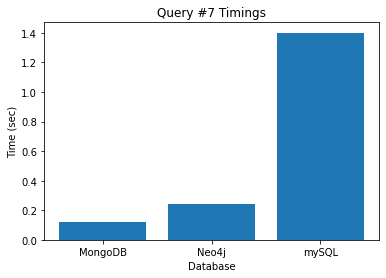

In [292]:
query_7_timings = []
#Run the queries to get thier timings
query_7_mongodb(query_7_timings)
query_7_neo4j(query_7_timings)
query_7_mysql(query_7_timings)
#Plot the timings
plot_timings("Query #7 Timings", query_7_timings)

### Timings Explination
MongoDB works the best for this type of query because it only needs to look in one table. Since the faction name is denormalized and included in the system's table, a seperate query or join does not need to take place in MongoDB. MongoDB works the best when it only needs to query on a single table. Neo4j also performs well for this type of query because it again can leverage its relationship from each faction to the system it controls. It is not as effecient at aggregating data which is why MongoDB performs just a little better. Lastly, mySQL still works in a reasonable amount of time, but performs the worst because it needs to do an expensive join operation to get the faction names.

## 8. Find the rarest module and where to buy it.

### MongoDB

In [296]:
def query_8_mongodb(timings=[]):
    #Get the module ids sold in the least places and the stations they are sold at
    query = [
        {'$project': {'name': 1, 'system_id': 1, 'selling_modules': 1}}, 
        {'$unwind': {'path': '$selling_modules', 'preserveNullAndEmptyArrays': False}}, 
        {
            '$group': {
                '_id': '$selling_modules', 
                'count': {
                    '$sum': 1
                }, 
                'system_ids': {
                    '$push': '$system_id'
                },
                'station_name': {
                    '$push': '$name'
                },
            }
        }, {
            '$group': {
                '_id': '$count', 
                'modules': {
                    '$push': {
                        'module_id': '$_id', 
                        'system_ids': '$system_ids',
                        'station_names': '$station_name'
                    }
                }
            }
        }, 
        {'$sort': {'_id': 1}}, 
        {'$limit': 1}
    ]
    start = timer()
    station_result = list(eddb['stations'].aggregate(pipeline=query, allowDiskUse=True))
    listing_result = []
    for row in station_result[0]['modules']:
        filter={'id': row['module_id']}
        project={'ed_symbol': 1}
        result = list(eddb['modules'].find(filter=filter, projection=project))
        module_name = result[0]['ed_symbol']
        for station in row['station_names']:
            station_name = station
        for system_id in row['system_ids']:
            filter={'id': system_id}
            project={'name': 1}
            result = list(eddb['systems_populated'].find(filter=filter, projection=project))
            system_name = result[0]['name']
        listing_result.append({'module_name': module_name, 'station_name': station_name, "system_name": system_name})
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return listing_result

In [168]:
result = query_8_mongodb()
for row in result:
    print(f"Rare module {row['module_name']} can be found at {row['station_name']} in {row['system_name']}")

Rare module Hpt_Guardian_ShardCannon_Turret_Large can be found at Ali Ring in Kokojina
Rare module Hpt_Guardian_PlasmaLauncher_Turret_Large can be found at Indigo Dock in Synuefe EN-H d11-96
Rare module Int_DroneControl_ResourceSiphon can be found at The Watchtower in Tir
Rare module Int_ShieldGenerator_Size1_Class1 can be found at The Brig in Luchtaine
Rare module Int_ShieldGenerator_Size1_Class2 can be found at The Brig in Luchtaine
Rare module Int_ShieldGenerator_Size1_Class3 can be found at The Brig in Luchtaine


### Neo4j

In [294]:
def query_8_neo4j(timings=[]):
    query = """
        MATCH (m:Module)-[:SOLD_AT]->(s:Station)
        WITH m, count(*) as total
        WITH total, collect(m) as modules
        ORDER BY total
        LIMIT 1
        UNWIND modules as m
        MATCH (m)-[:SOLD_AT]->(s:Station)
        WITH s, m
        MATCH (s)<-[:CONTAINS]-(sys:System)
        RETURN m.ed_symbol as ed_symbol, sys.name as system_name, s.name as station_name 
        """
    start = timer()
    result = session.run(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return result

In [152]:
result = query_8_neo4j()
for row in result:
    print(f"Rare module {row['ed_symbol']} can be found at {row['station_name']} in {row['system_name']}")

Rare module Hpt_Guardian_PlasmaLauncher_Turret_Large can be found at Indigo Dock in Synuefe EN-H d11-96
Rare module Int_ShieldGenerator_Size1_Class1 can be found at The Brig in Luchtaine
Rare module Int_ShieldGenerator_Size1_Class2 can be found at The Brig in Luchtaine
Rare module Int_ShieldGenerator_Size1_Class3 can be found at The Brig in Luchtaine
Rare module Hpt_Guardian_ShardCannon_Turret_Large can be found at Ali Ring in Kokojina
Rare module Int_DroneControl_ResourceSiphon can be found at The Watchtower in Tir


### mySQL

In [295]:
def query_8_mysql(timings=[]):
    query="""
    SELECT sys.name, station.name, module.ship, module.ed_symbol
    FROM selling_module
    JOIN station
    ON selling_module.station_id = station.id
    JOIN system_populated AS sys
    ON station.system_id = sys.id
    JOIN module
    ON module.id = selling_module.module_id
    WHERE selling_module.module_id IN (
        SELECT module_id
        FROM (
            SELECT module_id, COUNT(*) AS count
            FROM selling_module
            GROUP BY module_id
            ORDER BY count ASC
        ) sub
        WHERE sub.count = (SELECT MIN(count) FROM (
            SELECT module_id, COUNT(*) AS count
            FROM selling_module
            GROUP BY module_id
            ORDER BY count ASC
        ) sub2)
    )
    """
    start = timer()
    cursor.execute(query)

    results = cursor.fetchall()
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return results

In [161]:
result = query_8_mysql()
for row in result:
    print(f"Rare module {row[3]} can be found at {row[1]} in {row[0]}")

Rare module Hpt_Guardian_ShardCannon_Turret_Large can be found at Ali Ring in Kokojina
Rare module Int_ShieldGenerator_Size1_Class1 can be found at The Brig in Luchtaine
Rare module Int_ShieldGenerator_Size1_Class2 can be found at The Brig in Luchtaine
Rare module Int_ShieldGenerator_Size1_Class3 can be found at The Brig in Luchtaine
Rare module Int_DroneControl_ResourceSiphon can be found at The Watchtower in Tir
Rare module Hpt_Guardian_PlasmaLauncher_Turret_Large can be found at Indigo Dock in Synuefe EN-H d11-96


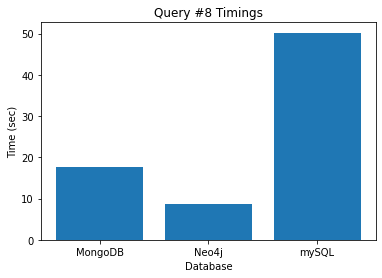

In [298]:
query_8_timings = []
#Run the queries to get thier timings
query_8_mongodb(query_8_timings)
query_8_neo4j(query_8_timings)
query_8_mysql(query_8_timings)
#Plot the timings
plot_timings("Query #8 Timings", query_8_timings)

## Timings Explination
Neo4j performs the best for this type of query because it can leverage its relationships. There is a relationship from a Module to all the stations they are sold at. Modules can then be grouped into the amount of times they are sold easily by just looking at the number of relationships of that type at the Module node itself. In this way, it can find all the rarest modules easily reducing the amount of data needed to get the system and station names. MongoDB performs better than mySQL because it splits the queries up so that it does not create such a large data set. mySQL does a costly join of all the necessary tables as well as querying the large selling_modules table an extra two times in order to get sub-data needed to get all the results. Because of this, mySQL performs the worst for this query.

## 9. Find the best path between two systems given the jump range of a ship.

In [ ]:
# Python graph builder and path finding using Dikjstra's

class System:
    def __init__(self, x, y, z, id, name):
        self.x = x
        self.y = y
        self.z = z
        self.name = name
        self.id = id

    def to_string(self):
        return f"{self.name},{self.x},{self.y},{self.z},{self.id}"

def mysql_to_class(mysql):
    return System(mysql[3], mysql[4], mysql[5], mysql[0], mysql[2])

def mysql_get_system_by_name(name):
    query = """
    SELECT *
    FROM system_populated
    WHERE name = '{id}'
    """.format(name=name)
    cursor.execute(query)
    systems = cursor.fetchall()
    return systems[0]

def mysql_get_all_systems():
    query = """
    SELECT *
    FROM system_populated
    """
    cursor.execute(query)
    mysql_systems = cursor.fetchall()
    systems = []
    for system in mysql_systems:
        systems.append(mysql_to_class(system))
    return systems

def economic_func(u, v, edge, prev_edge):
    return edge

def fastest_func(u, v, edge, prev_edge):
    return 1

def distance_between_systems(sys1, sys2):
    return ((sys1.x - sys2.x)**2 + (sys1.y - sys2.y)**2 + (sys1.z - sys2.z)**2)**0.5

# @param start : System to start path
# @param end : System to end path
# @param max_jump : 
# @param start System to start path
# @param start System to start path
# using System class
def trimmed_path(start, end, max_jump, buffer, systems):
    segment_length = distance_between_systems(start, end)
    max_sum_of_hypotenuse = buffer + segment_length
    graph = Graph()

    tot = 0

    for system_1 in systems:
        if max_sum_of_hypotenuse < distance_between_systems(system_1, start) + distance_between_systems(system_1, end):
            continue
        for system_2 in systems:
            if system_2.id == system_1.id:
                continue
            if max_sum_of_hypotenuse < distance_between_systems(system_2, start) + distance_between_systems(system_2, end):
                continue

            distance = distance_between_systems(system_1, system_2)
            if distance < max_jump:
                tot+=1
                graph.add_edge(system_1.id, system_2.id, distance)

    try:
        return True, find_path(graph, start.id, end.id, cost_func=economic_func)            
    except:
        return False, None, tot

### MongoDB

### Neo4j

In [185]:
def query_9_neo4j(current_system_name, end_system_name, jump_range, timings=[]):
    cypher_query = f'''MATCH (start:System {{name:{current_system_name}}}),(end:System{{name:'{end_system_name}}})
    CALL gds.alpha.shortestPath.stream({{
        nodeQuery:"MATCH (s:System) RETURN id(s) AS id",
        relationshipQuery: "MATCH (s1:System)-[r:DISTANCE]-(s2:System) WHERE r.lightYears < {jump_range} RETURN id(s1) AS source, id(s2) AS target, r.lightYears as lightYears",
        startNode: start, 
        endNode: end, 
        relationshipWeightProperty: 'lightYears'
    }})
    YIELD nodeId, cost
    RETURN gds.util.asNode(nodeId).name as name, cost'''

    start = timer()
    results = session.run(cypher_query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return results

In [184]:
current_system_name = 'Sol'
end_system_name = 'Nerthus'
result = query_9_neo4j(current_system_name, end_system_name, 21)
print(f"Path from {current_system_name} to {end_system_name}")
for row in result:
    print(row['name'])

Path from Sol to Nerthus
<Record name='Sol' cost=0.0>
<Record name='Epsilon Indi' cost=11.80240971158009>
<Record name='LHS 3836' cost=22.558676053810558>
<Record name='Segais' cost=36.94175802100382>
<Record name='Tiolce' cost=46.27023634345813>
<Record name='LHS 3802' cost=64.74998137856346>
<Record name='Nerthus' cost=74.88235716425658>


### mySQL

In [ ]:
def query_9_mysql(current_system_name, end_system_name, max_jump, buffer, timings=[]):
    t_start = timer()
    systems = mysql_get_all_systems()
    start = mysql_to_class(mysql_get_system_by_name(current_system_name))
    end = mysql_to_class(mysql_get_system_by_name(end_system_name))
    paths = trimmed_path(start, end, max_jump, buffer, systems)
    t_end = timer()
    timings.append(t_end - t_start)
    return paths

In [ ]:
current_system_name = 'Sol'
end_system_name = 'Nerthus'
result = query_9_neo4j(current_system_name, end_system_name, 21, 7)
print(f"Path from {current_system_name} to {end_system_name}")
for row in result:
    print(row)

In [ ]:
query_9_timings = []
#Run the queries to get thier timings
# query_9_mongodb(query_9_timings)
query_9_neo4j(query_9_timings)
query_9_mysql(query_9_timings)
#Plot the timings
plot_timings("Query #9 Timings", query_9_timings)

## 10. Build an aggregation of listing data to display the average buy price, average sell price, total supply, and total demand of the commodities.

### MongoDB

In [242]:
def query_10_mongodb(timings=[]):
    query = [
        {
            '$project': {'commodity_id': 1, 'sell_price': {'$cond': [{'$gt': ['$supply', 0]}, '$sell_price', None]}, 
                'supply': 1, 'buy_price': {'$cond': [{'$gt': ['$demand', 0]}, '$buy_price', None] }, 
                'demand': 1}}, {
            '$group': {
                '_id': '$commodity_id', 
                'avg_buy_price': {
                    '$avg': '$sell_price'
                }, 
                'avg_sell_price': {
                    '$avg': '$buy_price'
                }, 
                'total_demand': {
                    '$sum': '$demand'
                }, 
                'total_supply': {
                    '$sum': '$supply'
                }
            }
        }
    ]
    start = timer()
    listing_result = eddb['listings'].aggregate(query)
    commodity_aggregations = []
    for row in listing_result:
        commodity_name = get_commodity_name(row['_id'])
        avg_sell_price = 0
        if not row['avg_sell_price'] == None:
            avg_sell_price = row['avg_sell_price']
        avg_buy_price = 0
        if not row['avg_buy_price'] == None:
            avg_buy_price = row['avg_buy_price']
        commodity_aggregations.append({'commodity_name': commodity_name, 'avg_sell_price': avg_sell_price, 'avg_buy_price': avg_buy_price, 'total_supply': row['total_supply'], 'total_demand': row['total_demand']})
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return commodity_aggregations

In [238]:
result = query_10_mongodb()
for i in range(15):
    row = result[i]
    print(f"{row['commodity_name']} has an average sell price of {row['avg_sell_price']:.2f}, an average buy price of {row['avg_buy_price']:.2f}, a demand of {row['total_demand']}, and a supply of {row['total_supply']}")

Jadeite has an average sell price of 0.00, an average buy price of 0.00, a demand of 103794265, and a supply of 2
Painite has an average sell price of 0.00, an average buy price of 0.00, a demand of 79181891, and a supply of 5894
Heatsink Interlink has an average sell price of 0.00, an average buy price of 909.00, a demand of 33679851, and a supply of 493278
Samarium has an average sell price of 0.00, an average buy price of 0.00, a demand of 1463212222, and a supply of 2461
Progenitor Cells has an average sell price of 0.00, an average buy price of 5967.63, a demand of 406659072, and a supply of 38362638
Hardware Diagnostic Sensor has an average sell price of 0.00, an average buy price of 1536.08, a demand of 22503933, and a supply of 17214
Telemetry Suite has an average sell price of 0.00, an average buy price of 1536.08, a demand of 46227482, and a supply of 0
Exhaust Manifold has an average sell price of 0.00, an average buy price of 1269.86, a demand of 56866364, and a supply of 5

### Neo4j

In [223]:
def query_10_neo4j(timings=[]):
    query = f"""
        MATCH (c:Commodity)
        WITH c
        MATCH (c)-[r:BUY_AT]->(s:Station)
        WITH c, avg(r.buy_price) as avg_buy_price, sum(r.supply) as total_supply
        MATCH (c)-[r:SELL_AT]->(s:Station)
        RETURN c.name as commodity_name, avg_buy_price, total_supply, avg(r.sell_price) as avg_sell_price, sum(r.demand) as total_demand
        """
    start = timer()
    result = session.run(query)
    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return list(result)

In [224]:
result = query_10_neo4j()
for i in range(15):
    row = result[i]
    print(f"{row['commodity_name']} has an average sell price of {row['avg_sell_price']:.2f}, an average buy price of {row['avg_buy_price']:.2f}, a demand of {row['total_demand']}, and a supply of {row['total_supply']}")

Explosives has an average sell price of 689.77, an average buy price of 302.25, a demand of 994298914, and a supply of 1156035041
Hydrogen Fuel has an average sell price of 135.67, an average buy price of 90.52, a demand of 820511708, and a supply of 8622507996
Mineral Oil has an average sell price of 738.63, an average buy price of 200.60, a demand of 6467714306, and a supply of 743259878
Pesticides has an average sell price of 692.79, an average buy price of 166.79, a demand of 377868881, and a supply of 156641096
Clothing has an average sell price of 699.16, an average buy price of 336.58, a demand of 3535408662, and a supply of 542470455
Consumer Technology has an average sell price of 7497.65, an average buy price of 6115.66, a demand of 828662928, and a supply of 41859823
Domestic Appliances has an average sell price of 915.53, an average buy price of 535.81, a demand of 1049849983, and a supply of 339427170
Beer has an average sell price of 649.12, an average buy price of 185.79

### mySQL

In [240]:
def query_10_mysql(timings=[]):
    query = """
    SELECT commodity.name, SUM(buy_price), SUM(CASE WHEN supply > 0 THEN 1 ELSE 0 end) as total_buy_listings, SUM(sell_price), SUM(CASE WHEN demand > 0 THEN 1 ELSE 0 END) as total_sell_listings, SUM(supply), SUM(demand)
    FROM listing
    JOIN commodity
    ON listing.commodity_id = commodity.id
    GROUP BY commodity.name
    """

    start = timer()
    cursor.execute(query)
    results = cursor.fetchall()

    commodity_aggregations = []
    for row in results:
        avg_sell_price = 0
        if not row[4] == 0:
            avg_sell_price = row[3] / row[4]
        avg_buy_price = 0
        if not row[2] == 0:
            avg_buy_price = row[1] / row[2]
        commodity_aggregations.append({'commodity_name': row[0], 'average_sell_price': avg_sell_price, 'average_buy_price': avg_buy_price, 'demand': row[6], 'supply': row[5]})

    end = timer()

    elapsed_time = end - start
    timings.append(elapsed_time)

    return commodity_aggregations

In [220]:
result = query_10_mysql()
for i in range(15):
    row = result[i]
    print(f"{row['commodity_name']} has an average sell price of {row['average_sell_price']:.2f}, an average buy price of {row['average_buy_price']:.2f}, a demand of {row['demand']}, and a supply of {row['supply']}")

Explosives has an average sell price of 932.88, an average buy price of 302.25, a demand of 994298914, and a supply of 1156035041
Hydrogen Fuel has an average sell price of 4615.77, an average buy price of 90.53, a demand of 820511708, and a supply of 8622507996
Mineral Oil has an average sell price of 759.29, an average buy price of 200.60, a demand of 6467714306, and a supply of 743259878
Pesticides has an average sell price of 814.68, an average buy price of 166.79, a demand of 377868881, and a supply of 156641096
Clothing has an average sell price of 769.80, an average buy price of 336.58, a demand of 3535408662, and a supply of 542470455
Consumer Technology has an average sell price of 7667.49, an average buy price of 6115.66, a demand of 828662928, and a supply of 41859823
Domestic Appliances has an average sell price of 1040.25, an average buy price of 535.81, a demand of 1049849983, and a supply of 339427170
Animal Meat has an average sell price of 1909.58, an average buy price

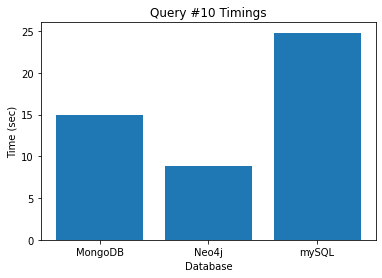

In [244]:
query_10_timings = []
#Run the queries to get thier timings
query_10_mongodb(query_10_timings)
query_10_neo4j(query_10_timings)
query_10_mysql(query_10_timings)
#Plot timings
plot_timings("Query #10 Timings", query_10_timings)

### Timings Explination
Neo4j performs the best in this type of query as well because it can leverage its relationships. Again, it does not have relationships for listings where a system does not buy or sell a certain item which reduces the amount of data it needs to aggregate. Because of this, the execution time is greatly reduced for this query. MongoDB performs second best in this query because it is split into two queries. Instead of doing a costly join, MongoDB first calculates all the aggregation data in the listings before doing individual small queries for the commodity name. mySQL performs worse because it does a costly join and needs additional manipulation of the data in order to find the average due to limitation in projecting buy/sell data which doesn't exist at a station, but still shows up with a price of zero in the listing.

## 11. (Neo4j Only) System Community Query

In [ ]:
RUN THIS TO CREATE GRAPH
CALL gds.graph.create.cypher('cypher-graph',
'MATCH (s:System) RETURN id(s) as id',
'MATCH (s:System)-[r:DISTANCE]-(s1:System) WHERE r.lightYears < 42 RETURN id(s) as source, id(s1) as target, type(r) as type')

RUN THIS TO COLLECT COMMUNITIES
CALL gds.louvain.stream('jump-graph')
YIELD nodeId, communityId
RETURN communityId, collect(gds.util.asNode(nodeId).name) as names